In [1]:

import random

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

SIFT algorithm is going to be used for keypoint extraction and feature description. The algorithm is going to be initialized as follows:

In [5]:
sift = cv.SIFT_create()

Next two images are going to be used for the demonstration of the algorithm. 
IMPORTANT: the images should be ordered from the left to the right.

In [8]:
img1 = cv.imread('./image pairs/image pairs_01_01.jpg')
img1 = cv.cvtColor(img1, cv.COLOR_RGB2BGR)
gray1= cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
kp1 = sift.detect(gray1,None)
img1sift=cv.drawKeypoints(gray1,kp1,gray1,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [9]:
img2 = cv.imread('./image pairs/image pairs_01_02.jpg')
img2 = cv.cvtColor(img2, cv.COLOR_RGB2BGR)
gray2= cv.cvtColor(img2,cv.COLOR_BGR2GRAY)
kp2 = sift.detect(gray2,None)
img2sift =cv.drawKeypoints(gray2,kp2,gray2,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

With the images open now the SIFT algorithm can be run on each of them. The keypoints and descriptors are going to be extracted and stored in the variables kp1, des1, kp2, des2.

Following are the two images with the descriptors visualized. It can be noted that some of the descriptors are similar and in similar positions in both images.

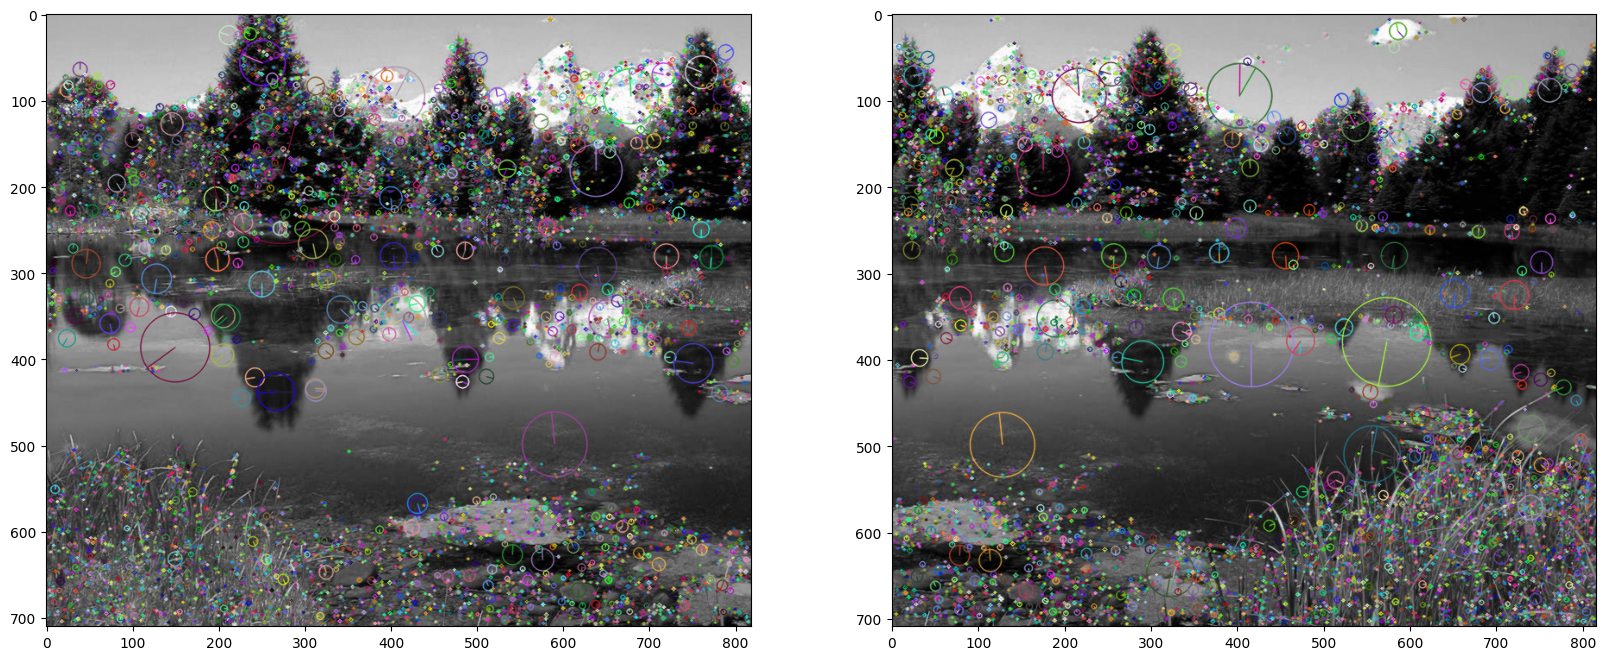

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
ax[0].imshow(img1sift)
ax[1].imshow(img2sift)
plt.show()


Now that the points have been computed, the next step is to match the points. This is done by using the FLANN algorithm. This Algorithm is faster than the brute force approach and gives the same accuracy. It involves trees and it is a best fit when the number of matches is high, which is exactly our case.

After matching the points a further refinement is done with the ratio test. This test is used to filter out the points that are not similar enough. The test is done by comparing the distance of the closest point to the distance of the second closest point. If the ratio is less than a certain threshold, the point is considered a good match.

The result is shown in the figure below. The matches are visualized with lines connecting the points. It can be seen that the matches are not perfect, this is why we are going to refine them in the next step.

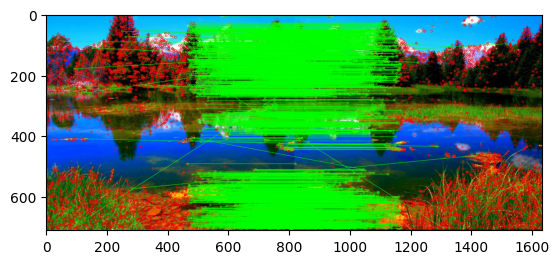

(<matplotlib.image.AxesImage at 0x1571581c0>, None)

In [11]:
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
good = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        good.append(m)
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()


From the previous image it can be seen that some green lines do not match corresponding keypoints. This is why we are going to use the RANSAC algorithm to further refine the matches. The RANSAC algorithm is going to be used to find the best transformation between the two images. The transformation is going to be used to warp the second image to the first one.

In [12]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ])[:4]
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ])[:4]

In particular the RANSAC algorithm works as follows:
1. Randomly select n points from the matches
2. Compute the transformation
3. Count the number of inliers, that is, if we take this transformation as the correct one, how many points are close to the transformed points (we need to consider all the points and not only the n points we used to compute the transformation)
4. Repeat the process for a number of iterations to find the best combination of points that minimizes the transformation error

Once the iteration is finished we can consider with a high degree of confidence that the current transformation is the closest to the real one. The transformation is then used to warp the second image to the first one.

In [19]:
import random

def transform(H, src):
    row = np.ones(src.shape[1])
    src = np.vstack([src, row])
    out = H @ src    
    return out[:-1] / out[-1]
    

def FindBestHomography(src_pts, dst_pts, ransacReprojThreshold=0.7, maxIters=1000, min_sample=100):
    
    best_inliers_count = 0
    best_inliers = np.zeros(len(src_pts), dtype=bool)
    best_residual_sum = np.inf    

    for i in range(maxIters):        
        indices = random.sample(range(0, len(src_pts)), k=min_sample)        
        src_, dst_ = src_pts[indices], dst_pts[indices]        
        H = myfindHomography(src_, dst_)
        est_dst = transform(H, src_pts.T)
        est_dst = est_dst.T
        inliers = np.zeros(len(src_pts), dtype=bool)
        distances = np.linalg.norm(est_dst - dst_pts, axis=1)
        inliers[distances < ransacReprojThreshold] = True
        curr_inliers_count = np.sum(inliers)
        curr_residual_sum = np.sum(distances)

        if curr_inliers_count > best_inliers_count:
            best_inliers_count = curr_inliers_count
            best_inliers = inliers
            best_residual_sum = curr_residual_sum            
        elif curr_inliers_count == best_inliers_count and curr_residual_sum < best_residual_sum:
            best_inliers_count = curr_inliers_count
            best_inliers = inliers
            best_residual_sum = curr_residual_sum
    
    inliers_indices = np.nonzero(best_inliers)[0]    
    H = myfindHomography(src_pts[inliers_indices], dst_pts[inliers_indices])    
    return H, inliers_indices

def myfindHomography(src_pts, dst_pts):

    assert src_pts.shape[0] >= 3  # Minimum 3 corresponding points are required
    assert src_pts.shape[0] == dst_pts.shape[0]  # The number of src points should be same as of dst points

    A = []
    for i in range(len(src_pts)):        
        x, y = src_pts[i]
        u, v = dst_pts[i]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.array(A)
    _, _, Vh = np.linalg.svd(A)
    L = Vh[-1,:] / Vh[-1,-1]
    H = L.reshape(3, 3)
    return H

All the code you see above seems gibberish, but is actually the implementation of the bullet points that I described earlier.

In particular:

```
def transform(...)
```
is responsible for transforming the source points to the destination points given any homgraphy matrix.

```
def myFindHomography(...)
```

Is responsible for finding the homography matrix given the source and destination points.

```
def findBestHomography(...)
```

Is responsible to run the RANSAC algorithm and find the best homography matrix. It calls many times both the previous functions to find the best homography matrix.

Next we can compute the best homography matrix and warp the second image to the first one. We also get the indices of the points that are inliers and we can visualize them. We remove all points that are not the best fits by applying the mask to the matches.

In [25]:
if len(good)>10:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ])
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ])    
    M, inliers_indices = FindBestHomography(src_pts, dst_pts, 0.5, 1000, 40)    
    matchesMask = [0 if i not in inliers_indices else 1 for i in range(len(good))]    
    # h,w, _ = img1.shape
    # pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    # dst = cv.perspectiveTransform(pts,M)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), 10) )
    matchesMask = None

We can visualize our predicted homography matrix and the refined matches. The result is shown in the figure below. It can be seen that the matches are now much better and the green lines are now connecting the correct keypoints.

In [26]:
M

array([[ 9.99962996e-01,  1.45216964e-05, -4.62984718e+02],
       [-1.84901804e-05,  1.00002364e+00,  8.65968096e-03],
       [-1.51650074e-08,  4.51000004e-08,  1.00000000e+00]])

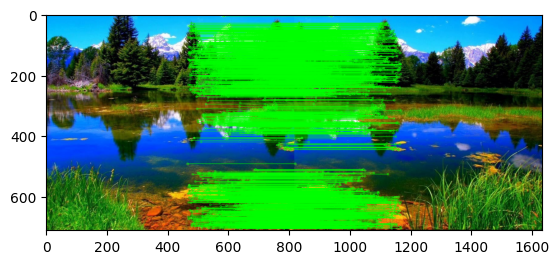

(<matplotlib.image.AxesImage at 0x16c2ca8c0>, None)

In [27]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()


The last part of the code involves creating a new frame for the images based on their projected new positions. The new frame is going to be the calculated from the new coordinates of the second image projected by the homography matrix and the original frame of the first image. The new frame is going to be the maximum of the two frames.

Then the function $\text{cv2.warpPerspective}$ is going to be used to warp the second image to the first one. The result is shown in the figure below. It can be seen that the second image is now warped to the first one and the two images are now aligned.

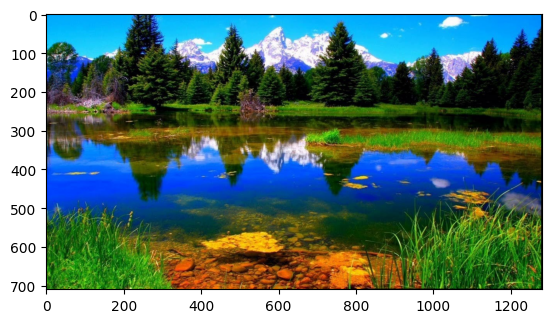

(<matplotlib.image.AxesImage at 0x1574155a0>, None)

In [30]:
# keep the corners

h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

corners1 = np.array([[0, 0], [0, h1], [w1, h1], [w1, 0]], dtype=np.float32).reshape(-1, 1, 2)
corners2 = np.array([[0, 0], [0, h2], [w2, h2], [w2, 0]], dtype=np.float32).reshape(-1, 1, 2)

warped_corners2 = cv.perspectiveTransform(corners2, M)

all_corners = np.concatenate((corners1, warped_corners2), axis=0)

[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

translation_dist = [-x_min, -y_min]
H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

warped_img2 = cv.warpPerspective(img1, H_translation @ M, (x_max - x_min, y_max - y_min))
warped_img2[translation_dist[1]:h2+translation_dist[1], translation_dist[0]:w2+translation_dist[0]] = img2

plt.imshow(warped_img2),plt.show()